# Language Detection

*Using Machine Learning to Classify 21 Languages Spokein in the EU*


In this notebook, I will show how I achieved an accuracy score of 99.7% on a testset that contains text from 21 different languages spoken in the EU.  My model classifies the language of the text. 

My explanations will split into three parts: **feature engineering, model selection, and model performance**.  



In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import chain
import glob2 as glob
from bs4 import BeautifulSoup
import pickle
import re

## Feature Engineering

My data consisted of 1.5 GB of .txt files partitioned amongst 21 languages.  The key questions that came into mind were:

### Question 1:  How should I deal with a heavy load of data?
* Although this is not considered 'big data', I experienced a bottleneck in the first stage of this project during data pre-processing.  Namely, it took around four hours to extract and clean all of the .txt files.  Suspecting the problems that could unfold later during model training, I conducted some research on language detection. I learned that pre-processing just a subset of this data would suffice for my objective.  Therefore, I tweaked my ```extract_clean_text()```  by defining some threshold on how much data I will extract from the files.
* Another problem I encountered with the data was that not all languages are treated equally.  In other words, extracting 100 txt files from the Bulgarian directory did not have the same amount of text as extracting 100 txt files from the Spanish directory. This realization of an imbalanced dataset was made when writing the code six cells down, where I used the np.unique function with return_counts setting to 'True'.  Therefore, I created a ```discrepancies``` list and added a nested threshold in my ```extract_clean_text()``` function to alleviate the discrepancy. 


### Question 2:  How should I tokenize the text?
* Tokenization is a necessary step before feeding the data into a model.  Tokenizing means splitting your text into minimal meaningful units. These units are generally called n-grams.  An n-gram is simply a subset of the text. This subset can be determined by defining the 'range' and 'analyzer' of the n-gram.  The 'range' defines the smallest and biggest size of the sliding window.  This sliding window determines how many n-grams will be generated given a line of text.  For example, the word 'kitty' would result with the following n-grams with a (1,3) window range: 'k', 'i', 't', 't', 'y', 'ki', 'it', 'tt', 'ty', 'kit', 'itt', 'tty'. 
* When I observed the data, I noticed that there were HTML markups and new line ('\n') annotations.  These are noise for the model, as they do not provide any meaningful information to detect language. Therefore, I used Beautiful Soup and Python's own split and join functions to clean up the text. 
* During my research on text tokenization, I realized that the tokenization method itself is a hyperparameter; namely, the type of tokenization can affect the performance of the model and therefore could be something to revise after analyzing the performance of the model.  Furthermore, the range and analyzer parameters within each tokenization method could also be hyperparameters to consider while tweaking the model.  
* I decided to use the TFIDFVectorizer.  What TFIDF does is assign an importance metric (weight) on n-grams based on how often they appear in the text.  The higher the weight, the rarer the n-gram. I hypothesized that rare n-grams could allow the model to learn the unique distinctions amongst the languages.  I chose 'char' as the analyzer, because for language detection, it only suffices to extract text on the character level.  I chose (1, 3) as my n-gram range because I hypothesized that this range could sufficiently capture the particular instances of the spelling of words in each language.  It is important to keep in mind that the n-gram range determines the dimensionality of this model's feature space.  Having a large range will cause the feature space to be more complex (i.e. more dimensions) and more sparse, which can affect the time it takes to train and apply the model.
    
### 3. What should the data structure look like before feeding it to a model? 
* For any ML model, you need a data structure that contains features (x) and targets (y).  
* Within the feature space, the values should be normalized.  In our case, TFIDF already takes normalization into account.  
* Within the target space, it's important to quantify the labels.  I used scikit learn's ```LabelEncoder()``` function to convert each language label into a unique number.  
* The data structure should also be shuffled, as this improves the quality of the ML model.  I used scikit learn's ```shuffle()``` function to do this.



In [116]:
LABELS= [
    'bg',
    'cs',
    'da',
    'de',
    'el',
    'en',
    'es',
    'et',
    'fi',
    'fr',
    'hu',
    'it',
    'lt',
    'lv',
    'nl',
    'pl',
    'pt',
    'ro',
    'sk',
    'sl',
    'sv'
]

# discrepancies: a list of countries in which the content in their text files is not as much as the other countries. 
# discprencies list will later be used to ensure that extracted text from coutnries are well balanced.
discrepancies = ['bg',
 'cs',
 'et',
 'hu',
 'lv',
 'lt',
 'pl',
 'ro',
 'sl',
 'sk'
]

#the value to each key is a path to a pickled file which contains clean text from the txt files.
language_directory = {
    'French': 'train_set/fr.p', 
    'Italian': 'train_set/it.p', 
    'Spanish': 'train_set/es.p', 
    'Portuguese': 'train_set/pt.p', 
    'Romanian': 'train_set/ro.p', 
    'English': 'train_set/en.p',
    'Dutch': 'train_set/nl.p',
    'German': 'train_set/de.p', 
    'Danish': 'train_set/da.p', 
    'Swedish': 'train_set/sv.p', 
    'Bulgarian': 'train_set/bg.p', 
    'Czech': 'train_set/cs.p', 
    'Polish': 'train_set/pl.p', 
    'Slovak': 'train_set/sk.p', 
    'Slovene': 'train_set/sl.p', 
    'Finnish': 'train_set/fi.p', 
    'Hungarian': 'train_set/hu.p', 
    'Estonian': 'train_set/et.p', 
    'Latvian': 'train_set/lv.p', 
    'Lithuanian': 'train_set/lt.p', 
    'Greek': 'train_set/el.p'
    
}

#p is used to parse out sentences from a provided string.
p = re.compile(r'[.?!]+')



In [16]:
def get_txt_path(countries):
    '''
    Goal:  Extract the .txt file paths from each country folder in order to initialize the
           data preprocessing.  
    
    @param countries: a list of the country abbreviations that are also the labels of the directories that contain
                      txt files.
    @return data_paths: a dictionary in which keys are country abbreviations and values are a list of 
                        strings that are txt file paths.
    '''
    data_paths = {}
    for i in countries:
        data_paths[i] = glob.glob(f'txt_raw_train/{i}/*.txt')
    return data_paths


def extract_clean_text(txt_files):
    '''
    Goal:  This is a crucial preprocessing step.  All raw text contain HTML markups which would be considered as noise to the model.
           Here, I extract certain amount of text from the countries' files.  If a country is in the discrepancies list, then more text will 
           be added to ensure a well balanced dataset.  
    
    @param txt_files: a string which is a path to the txt files from each country's directory
    @return cleantexts:  a list of strings from a certain amount of each country's txt files.
    '''
    
    cleantexts = []

    for file in txt_files:
        with open(file, 'rb') as txt:
            data = txt.read()
        cleantext = BeautifulSoup(data, 'lxml').text
        cleantext = ''.join(cleantext.split('\n'))
        cleantexts.append(cleantext)
        if country not in discrepancies: 
            if len(cleantexts)%100 == 0:
                break
        else:
            if len(cleantexts)%500 == 0:
                break
    return cleantexts


def generate_df(language):
    '''
    Goal:  To generate a Panda's dataframe that parses out the sentences of a given string and provides a label that corresponds
           to the language of that sentence.  
           
    @param language: a string that represents one of the 21 languages to classify.
    @return df: the pandas dataframe that will have two columns: 'Sentence' and 'language'.
    '''
    list_of_strings = pickle.load(open(language_directory[language], 'rb'))
    all_statements = []
    for text in list_of_strings:
        statements=  p.split(text)
        all_statements.append(statements)

    all_statements = list(chain.from_iterable(all_statements))
    df = pd.DataFrame(all_statements)
    df['language'] = language
    df= df.rename(index=str, columns={0:'Sentence'})
#     set_trace()
    return df


def generate_mega_df(dfs):
    '''
    Goal:  To concatenate each dataframe that is generated from the 'generate_df()' function to form one 'mega' dataframe.
        This mega dataframe will also use a label encoder as a way of quantifying the categories, in which case are languages.
    
    @param dfs: a list of Pandas dataframes.  
    @return df:  a Pandas dataframe which will contain three columns: 'Sentence','language', and 'label'.
    '''

    df = pd.concat(dfs)
    le = preprocessing.LabelEncoder()
    le.fit(df['language'])
    df['label'] = le.transform(df['language'])
    df['label'] = df['label'].apply(float)
    return df
    
    
def plot_confusion_matrix(y_test, predictions):
    '''
    Goal:  To visualize the performance of the model being used. 
    
    @param y_test: all true labels from the test set
    @param predictions: all predictions generated after predicting the model with the test input features
    
    '''
    
    plt.figure(figsize=(32, 32))
    cm = confusion_matrix(y_test, predictions)

    ax = sns.heatmap(cm, annot = True, fmt = "d")

    ax.set_xlabel('Predicted Language')
    ax.set_ylabel('Actual Language')
    ax.set_title('Language Identification Confusion Matrix')
    ax.set_xticklabels(dict_labels.values())
    ax.set_yticklabels(dict_labels.values())
    
    

In [10]:
data_paths = get_txt_path(labels)

for country, txt_paths in data_paths.items():
    cleantexts = extract_clean_text(txt_paths)
    pickle.dump(cleantexts, open(f'train_set/{country}.p','wb'))
    print(f'pickled file of clean text generated for {country}')


pickled file of clean text generated for bg
pickled file of clean text generated for cs
pickled file of clean text generated for da
pickled file of clean text generated for de
pickled file of clean text generated for el
pickled file of clean text generated for en
pickled file of clean text generated for es
pickled file of clean text generated for et
pickled file of clean text generated for fi
pickled file of clean text generated for fr
pickled file of clean text generated for hu
pickled file of clean text generated for it
pickled file of clean text generated for lt
pickled file of clean text generated for lv
pickled file of clean text generated for nl
pickled file of clean text generated for pl
pickled file of clean text generated for pt
pickled file of clean text generated for ro
pickled file of clean text generated for sk
pickled file of clean text generated for sl
pickled file of clean text generated for sv


In [100]:
dfs = []
for i in language_directory:
    dfs.append(generate_df(i))

df = generate_mega_df(dfs)


In [193]:
dict_labels = {}
for i in range(20):
    dict_labels[i]=df.loc[df['label'] == i]['language'][0]

In [101]:
labels = df['label']
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0.0: 32291,
 1.0: 33183,
 2.0: 38694,
 3.0: 31205,
 4.0: 29501,
 5.0: 36826,
 6.0: 29730,
 7.0: 29718,
 8.0: 34500,
 9.0: 23290,
 10.0: 33130,
 11.0: 27233,
 12.0: 35557,
 13.0: 38458,
 14.0: 34612,
 15.0: 28525,
 16.0: 29721,
 17.0: 33048,
 18.0: 31608,
 19.0: 33366,
 20.0: 32230}

In [21]:
# few_sentences = [0, 1, 5, 10, 12, 13, 14, 16, 17, 18]
# imbalanced_set = [17, 20]

# discrepancies = []
# for i in few_sentences:
#     discrepancies.append(df.loc[df['label'] == i]['language'][0])

# discrepancies = []
# for i in imbalanced_set:
#     discrepancies.append(df.loc[df['label'] == i]['language'][0])

In [102]:
df.isnull().any()

Sentence    False
language    False
label       False
dtype: bool

In [103]:
df = shuffle(df)

In [171]:
features = df['Sentence']
targets = df['label']

In [172]:
x_train, x_val, y_train, y_val = train_test_split(features, targets, test_size=0.3, random_state=0)

## Model Selection

I wanted to choose a model that would be friendly to sparse feature spaces. Thankfully, there are tons of ML models in sci-kit learn that accept sparse matrices.  I chose Multinomial Naive Bayes as my model, as it caters to sparse matrices and is a simple technique for constructing classifiers.  Naive Bayes (NB) is a probabilistic model, in the sense that it computes probabilities, and it assumes that the feature vectors in the feature space are linearly independent.  Linear independence means that there is no correlation between any of the columns in the feature space, i.e. there are no redundant vectors and each feature vector stands on its own.  To demonstrate this concept with a simple example, suppose you were given the task to classify vehicles of transportation, cars and bicycles, and you were given data on their attributes, weight and maximum speed.  If you ponder on how these two features are applied in the real world, you may think that the heavier the vehicle, the likelier it is that this vehicle has an engine, which is then most likely that the vehicle is a car.  In this instance, weight and speed are codependent and it would suffice to say that we can throw one of those features away.  In this case, weight and speed are not linearly independent.  However, this feature space could diminish its linear dependence quality if we were classifying cars and motorcycles.  In this case, weight and speed are not necessarily correlated with each other and we could say that these features are likely to be linearly independent.  With the case of language detection, I hypothesize that the features generated from TFIDF vectorization are indeed linearly independent. 

As mentioned earlier, NB computes probabilities.  Namely, it computes the following: what is the probability that this language is y given that it has features x?  In our instance, the model works by computing a large table of probabilities by using Baye's theorem to compute the conditional probability stated above.  Then, the highest probability gets predicted as the correct language.  





In [173]:
tfidf_vect = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
model = MultinomialNB()
text_clf = Pipeline([('tfidf', tfidf_vect),
                    ('clf', model),])

In [174]:
text_clf.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [175]:
predictions = text_clf.predict(x_val)

In [176]:
accuracy_score(y_val,predictions)

0.9772480879918001

In [36]:
import codecs
#open it with utf-8 encoding 
file =codecs.open("europarl.test","r",encoding='utf-8')
#read the file to unicode string
sfile=file.read()

#check the encoding type
print(type(file)) #it's unicode

#unicode should be encoded to standard string to display it properly
print(sfile.encode('utf-8'))
#check the type of encoded string

print(type(sfile.encode('utf-8')))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [44]:
test_one = sfile.split('\n')[:100]
test_two = sfile.split('\n')[100:200]
test_three= sfile.split('\n')[200:300]

In [53]:
unclean_sentences = ''.join(sfile.split('\n')).split('\t')

In [131]:
clean_sentences = []
for i in unclean_sentences:
    clean = re.sub('\(..\)', '', i)
    cleaner = re.sub('\...$', '', clean)
    clean_sentences.append(cleaner)

In [132]:
labels = []
for i in sfile.split('\n'):
    label = i[:2]
    labels.append(label)

In [133]:
print(len(clean_sentences))

21001


In [134]:
print(len(labels))

21001


In [135]:
df_test = pd.DataFrame(labels, clean_sentences)

In [136]:
df_test=df_test.drop(df_test.index[0]).reset_index()

In [149]:
df_test = df_test.rename(index=str, columns={'langauge':'language', 'index':'Sentence'})

In [150]:
df_test = shuffle(df_test)

In [151]:
df_test.head()

,Sentence,language
8707,Siirrymme äänestykseen,fi
9615,Les difficultés du pouvoir d'achat ont contrib...,fr
2215,Det er dog også værd at fremhæve de henvisning...,da
9671,Mais les Cambodgiens renvoient ensuite naturel...,fr
13300,Kad Eiropas karaspēks vai kāda cita palīdzība ...,lv


In [185]:
df_test = df_test.dropna()

In [195]:
dict_labels

{0: 'Bulgarian',
 1: 'Czech',
 2: 'Danish',
 3: 'Dutch',
 4: 'English',
 5: 'Estonian',
 6: 'Finnish',
 7: 'French',
 8: 'German',
 9: 'Greek',
 10: 'Hungarian',
 11: 'Italian',
 12: 'Latvian',
 13: 'Lithuanian',
 14: 'Polish',
 15: 'Portuguese',
 16: 'Romanian',
 17: 'Slovak',
 18: 'Slovene',
 19: 'Spanish'}

In [153]:
# ensuring that test data is label encoded teh same way as the training data
df_test.loc[df_test.language == 'fr', 'label'] = 7.0
df_test.loc[df_test.language == 'it', 'label'] = 11.0
df_test.loc[df_test.language == 'es', 'label'] = 19.0
df_test.loc[df_test.language == 'pt', 'label'] = 15.0
df_test.loc[df_test.language == 'ro', 'label'] = 16.0
df_test.loc[df_test.language == 'en', 'label'] = 4.0
df_test.loc[df_test.language == 'nl', 'label'] = 3.0
df_test.loc[df_test.language == 'de', 'label'] = 8.0
df_test.loc[df_test.language == 'da', 'label'] = 2.0
df_test.loc[df_test.language == 'sv', 'label'] = 20.0
df_test.loc[df_test.language == 'bg', 'label'] = 0.0
df_test.loc[df_test.language == 'cs', 'label'] = 1.0
df_test.loc[df_test.language == 'pl', 'label'] = 14.0
df_test.loc[df_test.language == 'sk', 'label'] = 17.0
df_test.loc[df_test.language == 'sl', 'label'] = 18.0
df_test.loc[df_test.language == 'fi', 'label'] = 6.0
df_test.loc[df_test.language == 'hu', 'label'] = 10.0
df_test.loc[df_test.language == 'et', 'label'] = 5.0
df_test.loc[df_test.language == 'lv', 'label'] = 12.0
df_test.loc[df_test.language == 'lt', 'label'] = 13.0
df_test.loc[df_test.language == 'el', 'label'] = 9.0


In [188]:
test_features = df_test['Sentence']
test_targets = df_test['label']

In [190]:
predictions = text_clf.predict(test_features)

## Model Performance

As seen below, the test data generates an accuracy score of 99.8%! The well defined diagonal is a visual representation of the good performance of this language classifier. Although this model performs quite well, there are a few misclassifications. The confusion matrix gives insight into where the model makes errors.

In [191]:
accuracy_score(test_targets, predictions)

0.997904662126768

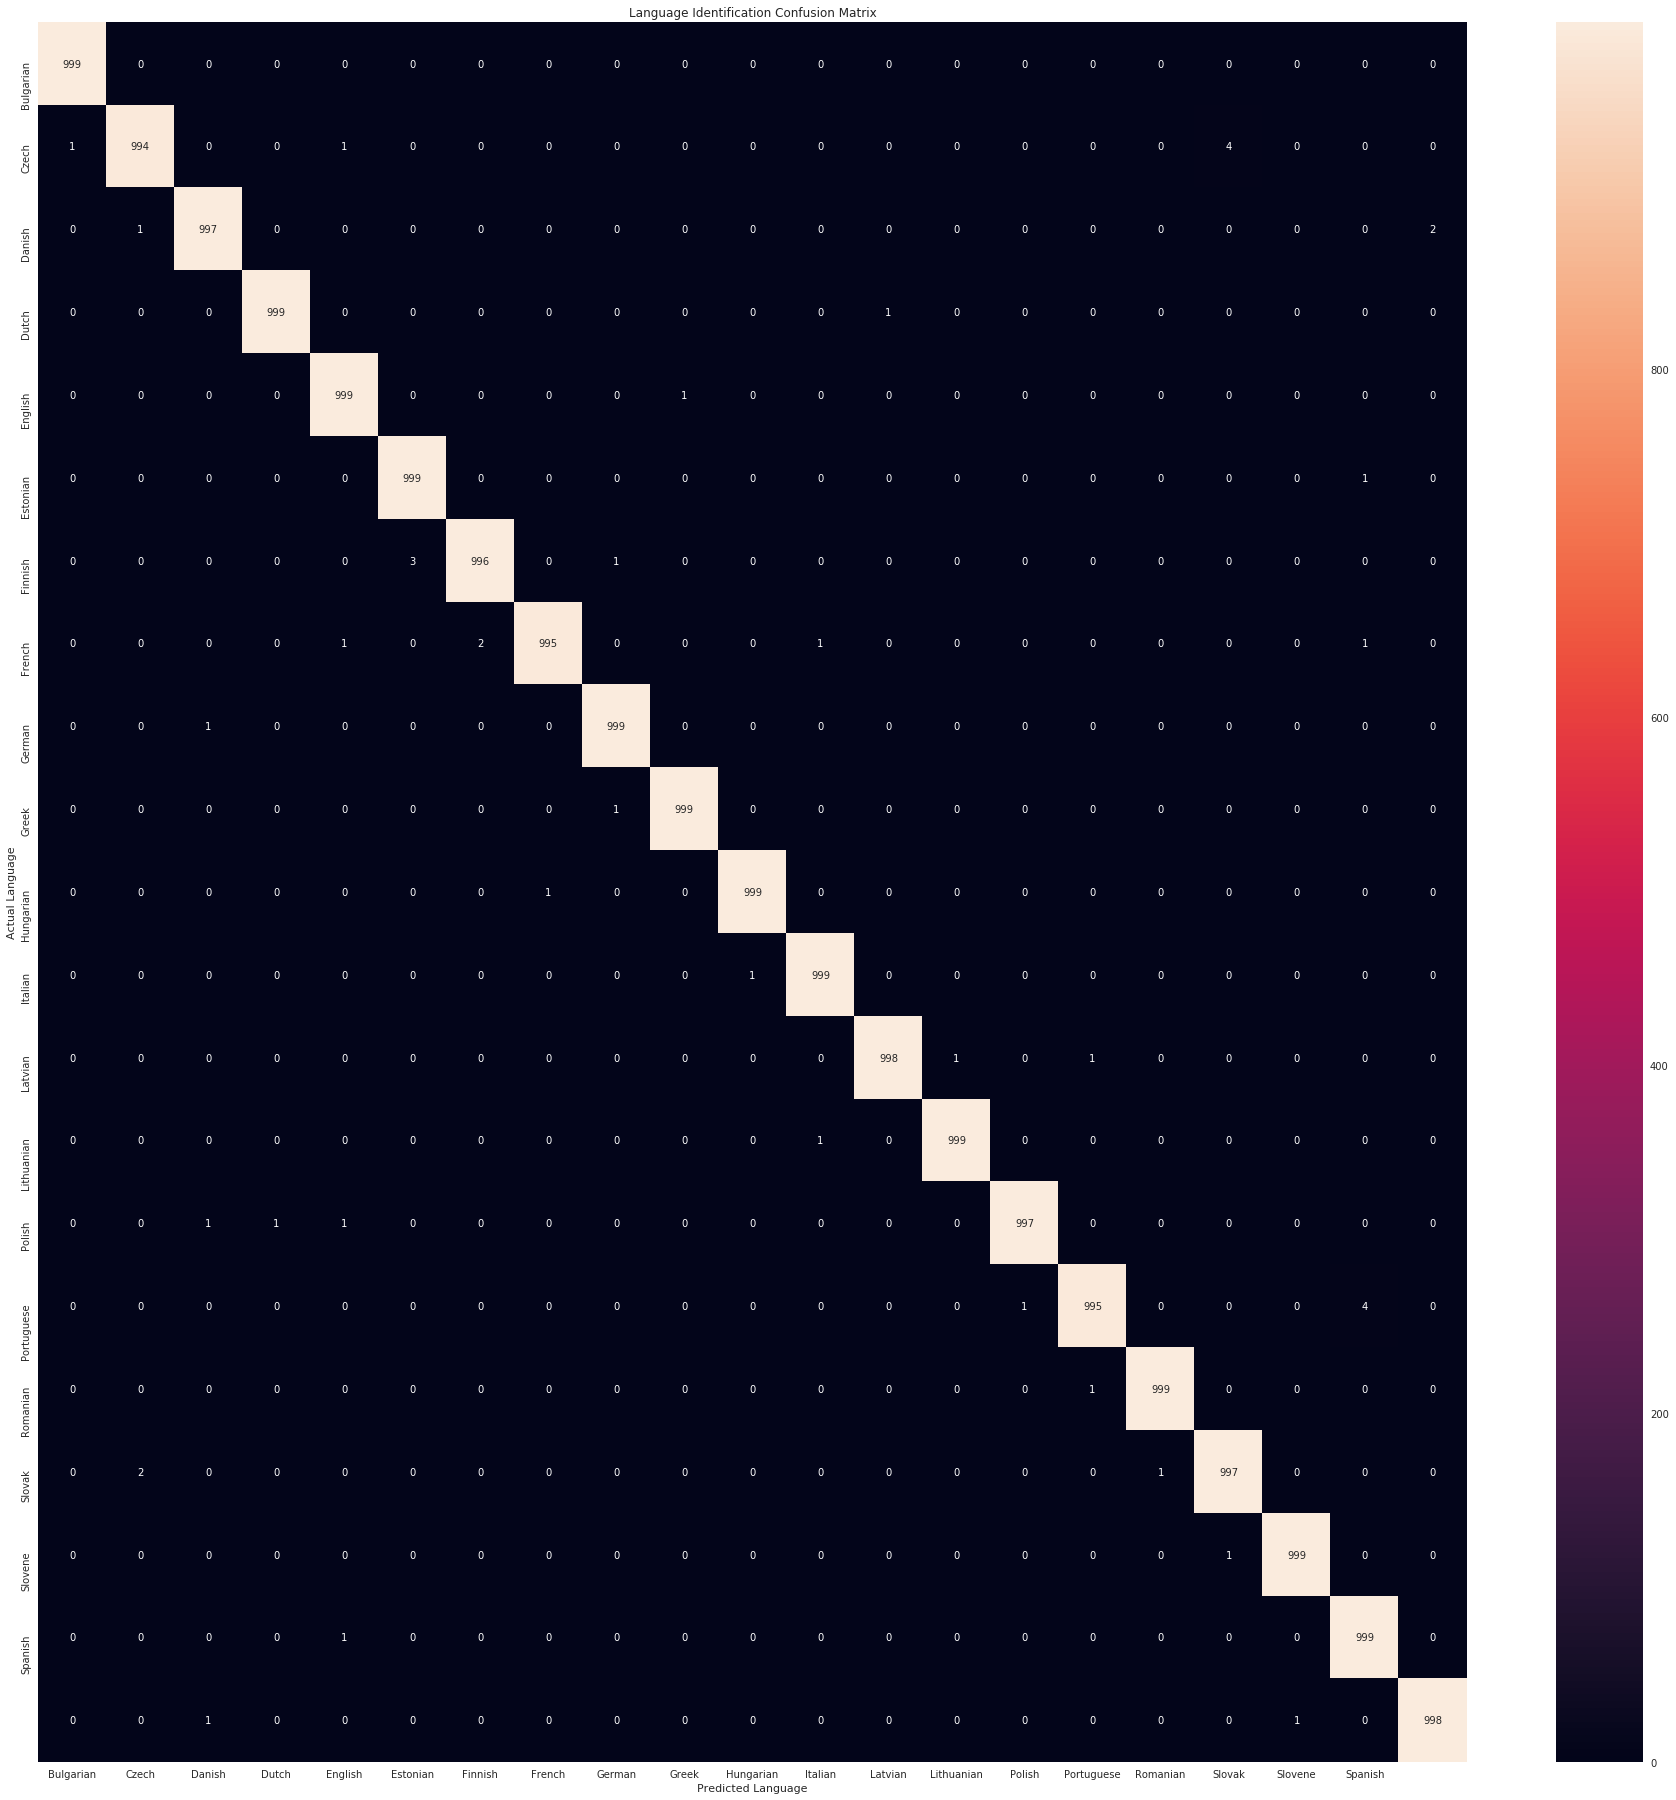

In [194]:
plot_confusion_matrix(test_targets, predictions)